In [1]:
import pandas as pd
import numpy as np
import requests
import json
from config import api_key
import flr_tools
import cme_tools
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as stats
from datetime import datetime as dt
from pandas.plotting import register_matplotlib_converters


In [2]:
# Date range to pull data from the APIs with
# We found there was data starting early 2010
start_date = "2010-01-01"
end_date = "2019-09-30"

## Pulling Data
Useful tools were created to pull and clean data from APIs for Solar Flares and CMEs. These tools helped to build dataframes that contain only columns we are interested in. The API pulls contained more information that we needed (i.e. instruments that recorded the entry)

In [3]:
# Using tools created in the data exploration and clean up process to pull data
# This is for pulling solar flare data
dont_use_nasa_time_format = False
flare_alldf = flr_tools.flare_query_all(start_date, end_date, dont_use_nasa_time_format)
flare_alldf.head()

,class_type,end_time(zulu),flare_id,linked_events,peak_time(zulu),power(w/m^2),start_time(zulu)
0,B7.4,"04/03/2010, 10:58:00",2010-04-03T09:04:00-FLR-001,[{'activityID': '2010-04-03T09:54:00-CME-001'}],"04/03/2010, 09:54:00",7.400000e-07,"04/03/2010, 09:04:00"
1,M2.0,"06/12/2010, 01:02:00",2010-06-12T00:30:00-FLR-001,[None Found.],"06/12/2010, 00:57:00",2.000000e-05,"06/12/2010, 00:30:00"
2,M1.0,"08/07/2010, 18:47:00",2010-08-07T17:55:00-FLR-001,[None Found.],"08/07/2010, 18:24:00",1.000000e-05,"08/07/2010, 17:55:00"
3,C4.4,"08/14/2010, 10:31:00",2010-08-14T09:38:00-FLR-001,[{'activityID': '2010-08-14T12:30:00-SEP-001'}],"08/14/2010, 10:05:00",4.400000e-06,"08/14/2010, 09:38:00"
4,C4.5,"08/18/2010, 06:51:00",2010-08-18T04:45:00-FLR-001,[{'activityID': '2010-08-18T06:00:00-CME-001'}],"08/18/2010, 05:48:00",4.500000e-06,"08/18/2010, 04:45:00"


In [4]:
# Using tools created in the data exploration and clean up process to pull data
# This is for pulling solar flare data
dont_use_nasa_time_format = False
cme_alldf = cme_tools.cme_query_all(start_date, end_date, dont_use_nasa_time_format)
cme_alldf.head()

,cme_id,speed,type,linked_events,start time
0,2010-04-03T09:54:00-CME-001,620,C,[{'activityID': '2010-04-03T09:04:00-FLR-001'}...,"04/03/2010, 09:54:00"
1,2010-06-13T07:32:00-CME-001,500,C,None,"06/13/2010, 07:32:00"
2,2010-06-20T03:18:00-CME-001,570,C,[{'activityID': '2010-06-23T08:00:00-IPS-001'}],"06/20/2010, 03:18:00"
3,2010-07-03T01:30:00-CME-001,625,C,None,"07/03/2010, 01:30:00"
4,2010-07-08T22:30:00-CME-001,290,S,None,"07/08/2010, 22:30:00"


## Looking at Linked Events
Once we had data for Solar Flares and CMEs, we looked at the linked events column.  The linked events column contained event IDs for any other solar weather event linked to the event we are looking at.  These IDs contain FLR for Solar Flares and CME for CMEs.  We used this to combine the two datasets where they were linked

In [5]:
# Using tools created in the data exploration and clean up process to pull data
# Creates list of events based on linked event type
cme_ids = cme_tools.linked_events(flare_alldf.rename(columns={'flare_id':'id'}),'CME')
flr_ids = cme_tools.linked_events(cme_alldf.rename(columns={'cme_id':'id'}),'FLR')
# Both lists are the same, just order of items different 
for i in range(len(cme_ids[:5])):
    print(cme_ids[i], flr_ids[i])

['2010-04-03T09:04:00-FLR-001', '2010-04-03T09:54:00-CME-001'] ['2010-04-03T09:54:00-CME-001', '2010-04-03T09:04:00-FLR-001']
['2010-08-18T04:45:00-FLR-001', '2010-08-18T06:00:00-CME-001'] ['2010-08-18T06:00:00-CME-001', '2010-08-18T04:45:00-FLR-001']
['2011-02-15T01:44:00-FLR-001', '2011-02-15T02:25:00-CME-001'] ['2011-02-15T02:25:00-CME-001', '2011-02-15T01:44:00-FLR-001']
['2011-02-24T07:23:00-FLR-001', '2011-02-24T08:00:00-CME-001'] ['2011-02-24T08:00:00-CME-001', '2011-02-24T07:23:00-FLR-001']
['2011-03-07T13:44:00-FLR-001', '2011-03-07T14:40:00-CME-001'] ['2011-03-07T14:40:00-CME-001', '2011-03-07T13:44:00-FLR-001']


In [6]:
# Creating dataframe from Solar Flare dataframe and CME dataframe that had IDs linked together
both = pd.DataFrame(cme_ids, columns=['flare_id','cme_id'])

# Merging dataframes by IDs and renaming columns as needed
new_df = both.merge(cme_alldf[["cme_id","speed","type","start time"]], on="cme_id", how='left')
new_df = new_df.rename(columns={"speed":"cme speed","type": "cme type", "start time": "cme start time"})
full_df = new_df.merge(flare_alldf[["flare_id","start_time(zulu)","peak_time(zulu)","end_time(zulu)","class_type","power(w/m^2)"]],
                      on="flare_id", how="left")
full_df = full_df.rename(columns={"start_time(zulu)":"flare start time","peak_time(zulu)": "flare peak time",
                                  "end_time(zulu)":"flare end time","class_type":"flare type","power(w/m^2)":"flare power(w/m^2)"})
full_df.head()

,flare_id,cme_id,cme speed,cme type,cme start time,flare start time,flare peak time,flare end time,flare type,flare power(w/m^2)
0,2010-04-03T09:04:00-FLR-001,2010-04-03T09:54:00-CME-001,620,C,"04/03/2010, 09:54:00","04/03/2010, 09:04:00","04/03/2010, 09:54:00","04/03/2010, 10:58:00",B7.4,7.400000e-07
1,2010-08-18T04:45:00-FLR-001,2010-08-18T06:00:00-CME-001,1091,O,"08/18/2010, 06:00:00","08/18/2010, 04:45:00","08/18/2010, 05:48:00","08/18/2010, 06:51:00",C4.5,4.500000e-06
2,2011-02-15T01:44:00-FLR-001,2011-02-15T02:25:00-CME-001,920,C,"02/15/2011, 02:25:00","02/15/2011, 01:44:00","02/15/2011, 01:56:00","02/15/2011, 02:06:00",X2.2,2.200000e-04
3,2011-02-24T07:23:00-FLR-001,2011-02-24T08:00:00-CME-001,900,C,"02/24/2011, 08:00:00","02/24/2011, 07:23:00","02/24/2011, 07:35:00","02/24/2011, 07:42:00",M3.5,3.500000e-05
4,2011-03-07T13:44:00-FLR-001,2011-03-07T14:40:00-CME-001,710,C,"03/07/2011, 14:40:00","03/07/2011, 13:44:00","03/07/2011, 14:30:00","03/07/2011, 15:08:00",M2.0,2.000000e-05


In [7]:
# Converting CME speed and Solar Flare power columns to numeric for analysis
full_df["cme speed"] = pd.to_numeric(full_df["cme speed"], errors="coerce")
full_df["flare power(w/m^2)"] = pd.to_numeric(full_df["flare power(w/m^2)"], errors="coerce")
cme_alldf["speed"] = pd.to_numeric(cme_alldf["speed"], errors="coerce")

## Checking Our Hypothesis
### Does the speed of a Coronal Mass Ejection (CME) affect the power of a Solar Flare?
* <span style="color:blue"><b>NULL HYPOTHESIS:</b></span> If a CME is faster,
                   then there will be no affect on the power of a coinciding solar flare.
* <span style="color:blue"><b>ALTERNATE HYPOTHESIS:</b></span> If a CME is faster,
                        then a coinciding solar flare will be more powerful

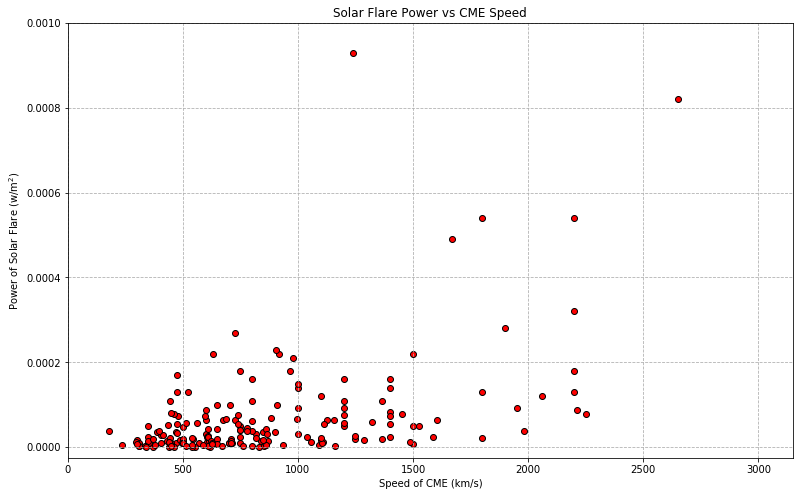

In [8]:
plt.figure(figsize=(13,8))
plt.scatter(full_df["cme speed"], full_df["flare power(w/m^2)"], facecolor='r', edgecolor='k')
plt.ylim(-0.000025, 10*10**-4)
plt.xlim(0,full_df["cme speed"].max()+500)
plt.title("Solar Flare Power vs CME Speed")
plt.xlabel("Speed of CME (km/s)")
plt.ylabel("Power of Solar Flare (w/m$^2$)")
plt.grid(linestyle='--')

In [9]:
# Remove columns with missing data
test_df = full_df.dropna(how="any")

In [10]:
# Performing Students T-Test (independent) to check Hypothesis
tstat,p = stats.ttest_ind(test_df["cme speed"], test_df["flare power(w/m^2)"], equal_var = False)

In [11]:
print(tstat,round(p,100))

24.502448665273498 3.943576030993236e-60


### Results:
Our p-value is {{p}}!  This is very small!  This means that our Null Hypothesis is correct.  The speed of a CME has no affect on the power of a solar flare

## Question:
### How often are solar flares linked to CME.  
It turns out CMEs are far more common than Solar Flares.  Solar Flares frequently happen without a coinciding CME

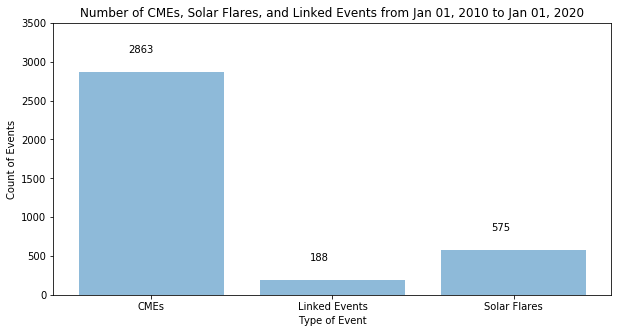

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
object_list = ["CMEs", "Linked Events","Solar Flares"]
counts = [len(cme_alldf), len(full_df), len(flare_alldf)]
plt.bar(np.arange(len(object_list)),counts, align="center", alpha=0.5)
plt.xticks(np.arange(len(object_list)),object_list)
plt.title(f"Number of CMEs, Solar Flares, and Linked Events from {dt(2010,1,1).strftime('%b %d, %Y')} to {dt(2020,1,1).strftime('%b %d, %Y')}")
plt.ylabel("Count of Events")
plt.xlabel("Type of Event")
plt.ylim(0,3500)
             
             
# for x in range(len(counts)):
#           ax.text(x, 5, str(counts[x]), color = 'k')
             
for i,v in enumerate(counts):
             plt.text(i-.125, v+250, str(v), color='k')

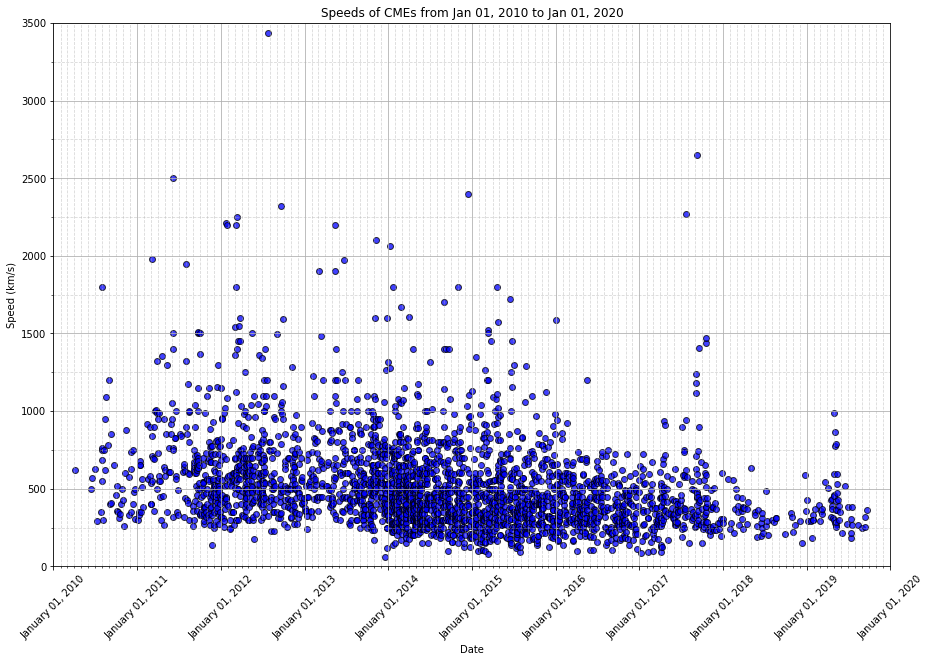

In [13]:
register_matplotlib_converters()
fig, ax = plt.subplots(figsize=(15,10))
cme_clean_df = cme_alldf[['cme_id','speed','start time']].dropna(how="any")

dates = cme_clean_df["start time"].apply(lambda x: dt.strptime(x,'%m/%d/%Y, %H:%M:%S'))

ax.scatter(dates, cme_clean_df['speed'], facecolor = 'b', alpha = .75, edgecolor='k')

ax.set_title(f"Speeds of CMEs from {dt(2010,1,1).strftime('%b %d, %Y')} to {dt(2020,1,1).strftime('%b %d, %Y')}")
ax.set_xlabel("Date")
ax.set_xticklabels(dates,rotation=45)
ax.set_ylabel("Speed (km/s)")
ax.set_xlim(dt(2010,1,1), dt(2020,1,1))
ax.set_ylim(0,3500)


years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
fmt = mdates.DateFormatter('%B %d, %Y')

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(fmt)
ax.xaxis.set_minor_locator(months)

ax.set_yticks(np.arange(0,4000,500))
ax.set_yticks(np.arange(0,3750,250), minor=True)
ax.grid(which='major', alpha=1, linestyle='-')
ax.grid(which='minor', alpha=0.5, linestyle='--')

In [14]:
# The path to our CSV file
file = "../data/sunspots.csv."

# Read our purchase data into pandas
df = pd.read_csv(file,delimiter = ';',header = None)
df.head()

,0,1,2,3,4,5,6
0,1749,1,1749.042,96.7,-1.0,-1,1
1,1749,2,1749.123,104.3,-1.0,-1,1
2,1749,3,1749.204,116.7,-1.0,-1,1
3,1749,4,1749.288,92.8,-1.0,-1,1
4,1749,5,1749.371,141.7,-1.0,-1,1


In [15]:
df = df[[0,1,3]]
df.head()

,0,1,3
0,1749,1,96.7
1,1749,2,104.3
2,1749,3,116.7
3,1749,4,92.8
4,1749,5,141.7


In [16]:
df.rename(columns={0: "Year", 1: "Month", 3:"Sunspots"},inplace = True)
df.head()

,Year,Month,Sunspots
0,1749,1,96.7
1,1749,2,104.3
2,1749,3,116.7
3,1749,4,92.8
4,1749,5,141.7


In [17]:
sunspots= df.loc[df["Year"] > 2009, [
    "Year", "Month", "Sunspots"]]
sunspots.head()

,Year,Month,Sunspots
3132,2010,1,19.5
3133,2010,2,28.5
3134,2010,3,24.0
3135,2010,4,10.4
3136,2010,5,13.9


In [18]:
#Converting Year,Month,DAy to Date
months = []
for i,row in sunspots.iterrows():
    months.append(dt(int(row['Year']),int(row['Month']), 1).strftime("%Y-%m-%d"))



In [19]:
#Converting Year,Month to Date
sunspots["Date"]=months
sunspots.head()

,Year,Month,Sunspots,Date
3132,2010,1,19.5,2010-01-01
3133,2010,2,28.5,2010-02-01
3134,2010,3,24.0,2010-03-01
3135,2010,4,10.4,2010-04-01
3136,2010,5,13.9,2010-05-01


In [20]:
sunspots = sunspots[["Date","Sunspots"]]
sunspots.head()

,Date,Sunspots
3132,2010-01-01,19.5
3133,2010-02-01,28.5
3134,2010-03-01,24.0
3135,2010-04-01,10.4
3136,2010-05-01,13.9


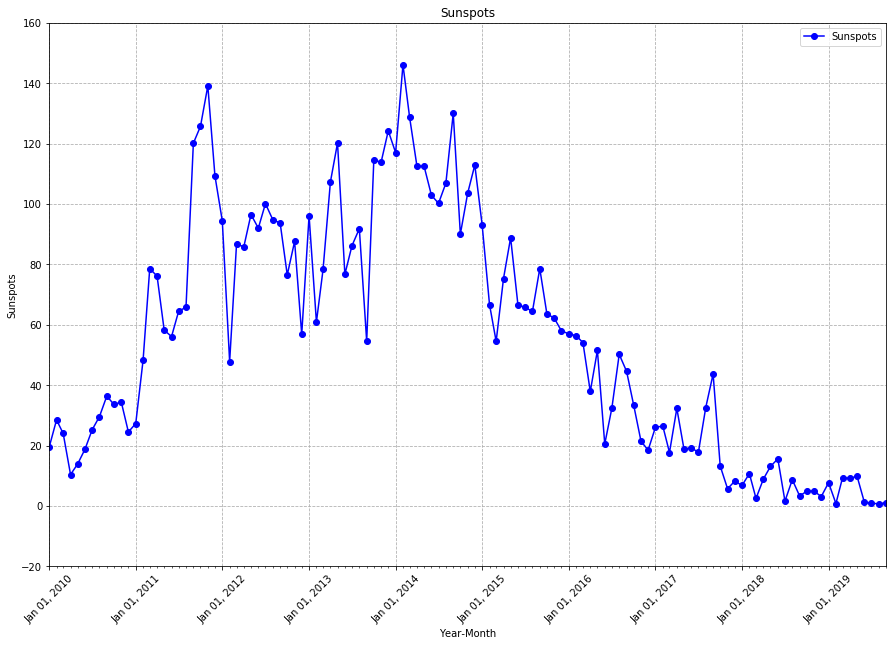

In [21]:
#Plot line graph
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
fig,ax = plt.subplots(figsize= (15,10))
x_axis = sunspots['Date'].apply(lambda x: dt.strptime(x,"%Y-%m-%d"))
Sunspot_plot = plt.plot(x_axis, sunspots['Sunspots'], marker ='o', color='blue', label="Sunspots")
dates = sunspots['Date']
ax.set_xticklabels(dates,rotation = 45)
ax.set_xlim(dt(2010,1,1),dt(2019,9,1))
ax.set_ylim(-20,160)

years = mdates.YearLocator()#every year
months = mdates.MonthLocator()#every month
fmt = mdates.DateFormatter('%b %d, %Y')

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(fmt)
ax.xaxis.set_minor_locator(months)                          
# Add legend
plt.legend(loc="best")

# Add labels
plt.title('Sunspots')
plt.xlabel('Year-Month')
plt.ylabel('Sunspots')
    
# Add gridlines
plt.grid(True,linestyle='dashed')
plt.show() 

In [22]:
months_CME = []
months_SF = []

dates_CME = cme_alldf['start time']
dates_SF = flare_alldf['start_time(zulu)']

for date in dates_CME:
    months_CME.append(dt.strptime(date, '%m/%d/%Y, %H:%M:%S').strftime("%y-%m"))
    
for date in dates_SF:
    months_SF.append(dt.strptime(date, '%m/%d/%Y, %H:%M:%S').strftime("%y-%m"))

    
dates_CME = []
dates_SF = []

unique_months_CME = []
unique_months_SF = []

count_CME = []
count_SF = []

for month in months_CME:
    if month not in unique_months_CME:
        unique_months_CME.append(month)
        
for month in months_SF:
    if month not in unique_months_SF:
        unique_months_SF.append(month)
        
for month in unique_months_CME:
    count_CME.append(months_CME.count(month))
    
for month in unique_months_SF:
    count_SF.append(months_SF.count(month))
    
    
CME_dict = {'Month': unique_months_CME,
           'CME Count': count_CME}

SF_dict = {'Month': unique_months_SF,
          'SF Count': count_SF}

CME_count_df = pd.DataFrame(CME_dict)
SF_count_df = pd.DataFrame(SF_dict)

combined_count_df = pd.merge(left=CME_count_df, right=SF_count_df, how='outer')
combined_count_df.fillna(0, inplace=True) 

combined_count_df['SF Count'] = combined_count_df['SF Count'].astype(int)

combined_count_df.head()

,Month,CME Count,SF Count
0,10-04,1,1
1,10-06,2,1
2,10-07,4,0
3,10-08,11,3
4,10-09,5,0


NameError: name 'solar_flare_count' is not defined

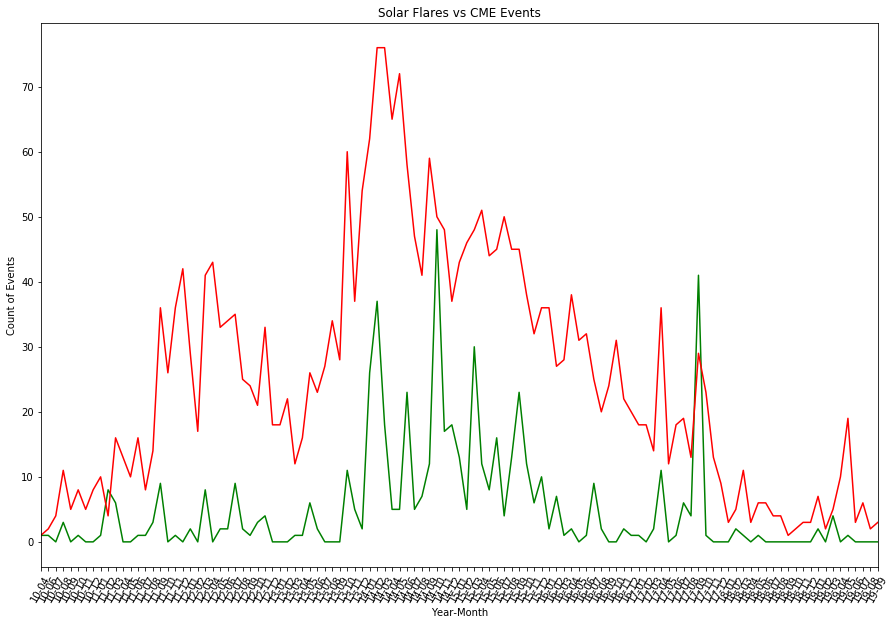

In [23]:
fig, ax = plt.subplots(figsize=(15,10))

ax.plot(combined_count_df['Month'], combined_count_df['SF Count'], color='green')
ax.plot(combined_count_df['Month'], combined_count_df['CME Count'], color ='red')

dates = combined_count_df['Month'] #.apply(lambda x: dt.strptime(x,"%y-%m"))

ax.set_title('Solar Flares vs CME Events')
ax.set_xlabel('Year-Month')
ax.set_ylabel('Count of Events')
ax.set_xticklabels(dates, rotation=60)
ax.set_xlim(dates[0],dates[-1:])
ax.legend(handles=[solar_flare_count, cme_count], loc="best")

years = mdates.YearLocator()
months = mdates.MonthLocator()
fmt = mdates.DateFormatter('%b %d, %Y')

#ax.xaxis.set_major_locator(years)
#ax.xaxis.set_major_formatter(fmt)
#ax.xaxis.set_minor_locator(months)

ax.set_yticks(np.arange(0,100,10))
ax.set_yticks(np.arange(0,100,5), minor=True)
ax.grid("--",which='major', alpha=0.5, linestyle='--')